# Notebook 04 — Model Curves and Metrics

This notebook loads saved outputs (hybrid_metrics.json, ROC/PR arrays) and plots ROC/PR for CatBoost and Hybrid on val/test splits. It’s the go-to place for quick performance readouts and to confirm the evaluation protocol is applied consistently.

## Mathematical overview and metrics

- **Splits**: `val` and `test` come from held-out years; no overlap with training.
- **Curves**: ROC (TPR vs FPR) and PR (Precision vs Recall) summarize classifier ranking quality.
- **AUC / AP**: Area Under ROC and Average Precision; higher is better. We show both CatBoost alone and the Hybrid blend.
- **Files loaded**: `data/interim/hybrid_metrics.json` (scalar metrics) and saved probability arrays for val/test.
- **Plots in this notebook**:
  1) ROC curves (CatBoost vs Hybrid) for val/test.
  2) PR curves (CatBoost vs Hybrid) for val/test.
  3) Metric table for quick comparison.

Goal: provide a clear, quantitative comparison of CatBoost and the Hybrid model under the fixed evaluation protocol.

# 04 – Model Performance & Ablations

Load metrics/predictions and visualize ROC/PR; optional light ablation on label quantile if available.

In [7]:
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

INTERIM = Path('data/interim')
with open(INTERIM / 'hybrid_metrics.json') as f:
    metrics = json.load(f)
print(json.dumps(metrics, indent=2))

# Load probabilities / labels
cb_val = np.load(INTERIM / 'catboost_prob_val.npy')
cb_test = np.load(INTERIM / 'catboost_prob_test.npy')
y_val = np.load(INTERIM / 'y_val_deficit_label.npy')
y_test = np.load(INTERIM / 'y_test_deficit_label.npy')

hyb_val = np.load(INTERIM / 'hybrid_risk_val.npy')
hyb_test = np.load(INTERIM / 'hybrid_risk_test.npy')


{
  "svd": {
    "rank": 1,
    "explained_variance_ratio": [
      0.986250102519989
    ]
  },
  "catboost": {
    "roc_auc_train": 0.9999201022690956,
    "roc_auc_val": 0.9917710196779964,
    "roc_auc_test": 0.9605978260869565,
    "average_precision_val": 0.9936576860789879,
    "average_precision_test": 0.9456646161809206,
    "f1_at_0_5_val": 0.9523809523809523,
    "f1_at_0_5_test": 0.7857142857142857
  },
  "autoencoder": {
    "train_recon_mse": 0.2602612376213074,
    "healthy_train_samples": 168
  },
  "hybrid": {
    "roc_auc_val": 0.9917710196779964,
    "roc_auc_test": 0.9646739130434783,
    "average_precision_val": 0.9948292175389808,
    "average_precision_test": 0.9538909007659008,
    "f1_at_tau_val": 0.9354838709677419,
    "f1_at_tau_test": 0.7407407407407407,
    "tau": 0.3098607361316681,
    "train_f1_at_tau": 0.9966555183946488
  }
}


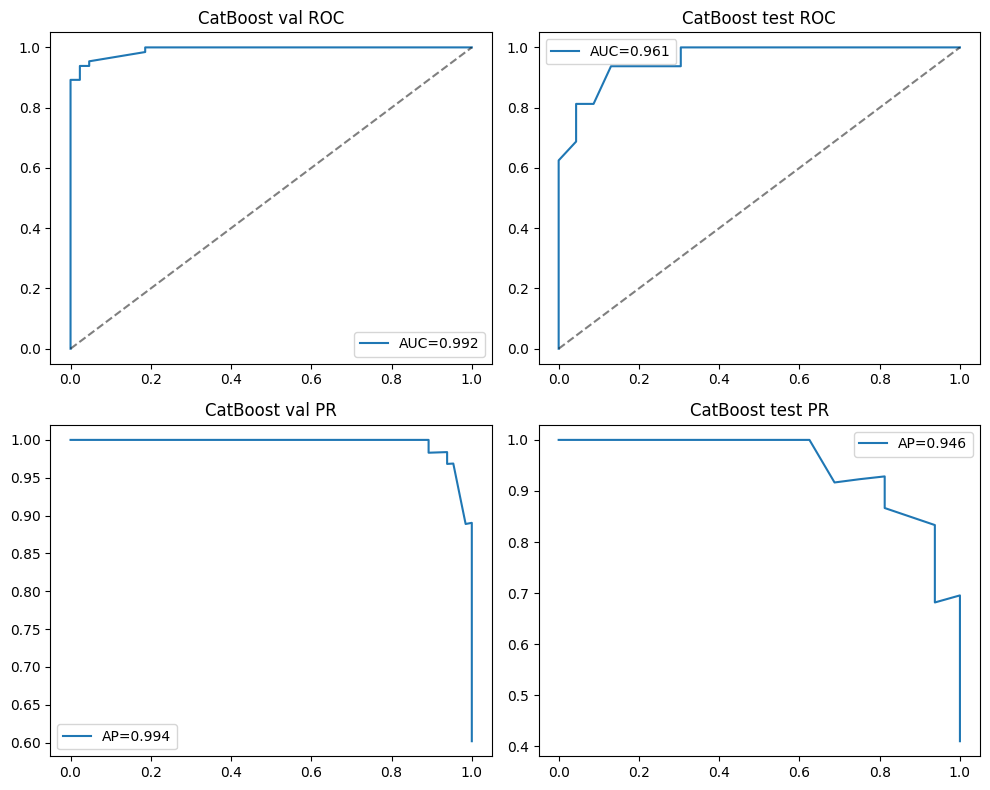

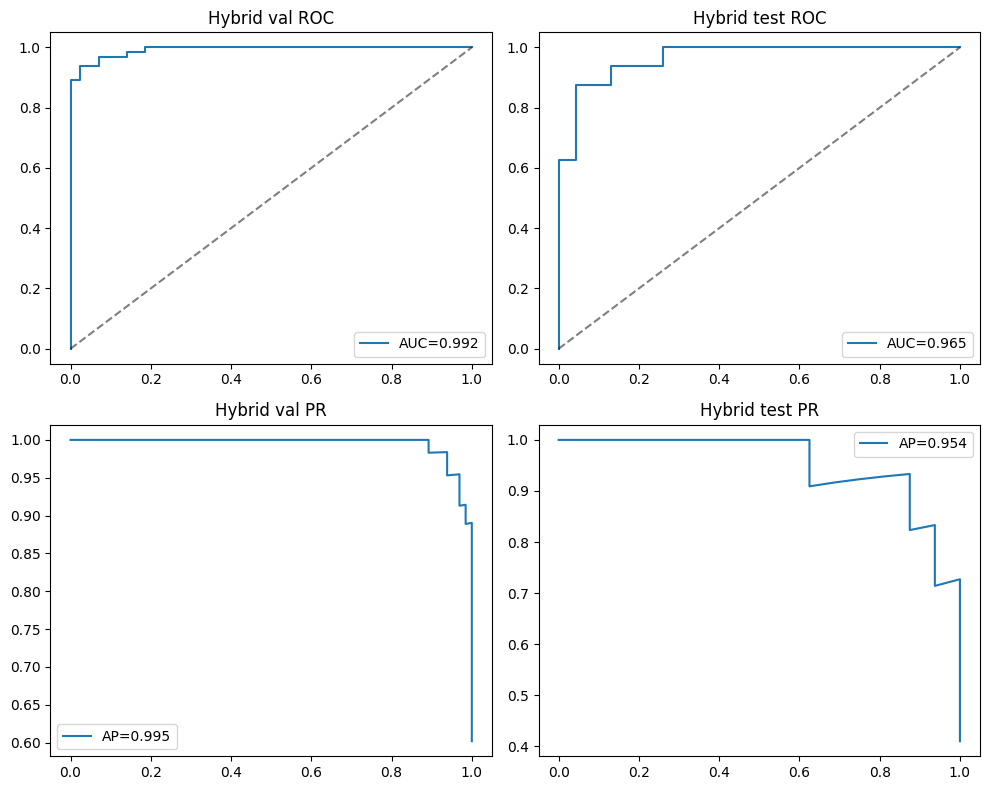

In [8]:
# ROC/PR for val/test (CatBoost and Hybrid)
fig, axes = plt.subplots(2,2, figsize=(10,8))

for preds, y, title, ax_roc, ax_pr in [
    (cb_val, y_val, 'CatBoost val', axes[0,0], axes[1,0]),
    (cb_test, y_test, 'CatBoost test', axes[0,1], axes[1,1]),
]:
    fpr, tpr, _ = roc_curve(y, preds)
    prec, rec, _ = precision_recall_curve(y, preds)
    ax_roc.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    ax_roc.plot([0,1],[0,1],'k--',alpha=0.5)
    ax_roc.set_title(title + ' ROC')
    ax_roc.legend()
    ax_pr.plot(rec, prec, label=f"AP={average_precision_score(y,preds):.3f}")
    ax_pr.set_title(title + ' PR')
    ax_pr.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2,2, figsize=(10,8))
for preds, y, title, ax_roc, ax_pr in [
    (hyb_val, y_val, 'Hybrid val', axes[0,0], axes[1,0]),
    (hyb_test, y_test, 'Hybrid test', axes[0,1], axes[1,1]),
]:
    fpr, tpr, _ = roc_curve(y, preds)
    prec, rec, _ = precision_recall_curve(y, preds)
    ax_roc.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
    ax_roc.plot([0,1],[0,1],'k--',alpha=0.5)
    ax_roc.set_title(title + ' ROC')
    ax_roc.legend()
    ax_pr.plot(rec, prec, label=f"AP={average_precision_score(y,preds):.3f}")
    ax_pr.set_title(title + ' PR')
    ax_pr.legend()

plt.tight_layout()
plt.show()


In [9]:

import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

tau = metrics['hybrid']['tau']

rows = []
for split, y, cb, hyb in [
    ('val', y_val, cb_val, hyb_val),
    ('test', y_test, cb_test, hyb_test),
]:
    rows.append({
        'split': split, 'model': 'catboost',
        'roc_auc': roc_auc_score(y, cb),
        'ap': average_precision_score(y, cb),
        'f1_at_tau': f1_score(y, cb >= tau),
    })
    rows.append({
        'split': split, 'model': 'hybrid',
        'roc_auc': roc_auc_score(y, hyb),
        'ap': average_precision_score(y, hyb),
        'f1_at_tau': f1_score(y, hyb >= tau),
    })

table = pd.DataFrame(rows).set_index(['split','model']).round(3)

delta = (table.xs('hybrid', level='model') - table.xs('catboost', level='model')).round(3)
delta['model'] = 'delta (hyb - cb)'
delta = delta[['roc_auc','ap','f1_at_tau']]

display(table)
print(f"Hybrid - CatBoost delta (common tau={tau:.3f}):")
display(delta)


roc_auc     ap  f1_at_tau
split model                              
val   catboost    0.992  0.994      0.953
      hybrid      0.992  0.995      0.935
test  catboost    0.961  0.946      0.786
      hybrid      0.965  0.954      0.741

Hybrid - CatBoost delta (common tau=0.310):


,roc_auc,ap,f1_at_tau
split,,,
val,0.000,0.001,-0.018
test,0.004,0.008,-0.045


## Quantitative comparison

Hybrid preserves CatBoost performance on val and slightly improves ranking metrics on test. Table shows ROC-AUC, AP, and F1 at a common threshold (`tau` from the hybrid calibration) for both models so the comparison is apples-to-apples.

## Optional: quantile ablation
You can rerun `prepare_dataset` with a different `NDRE_DEFICIT_Q` and reload metrics to compare class rates and AUC/AP. Keep the train/val/test split fixed and avoid tuning on test.